# Make MLZ input catalog of [1-1], [2-1], and [1-2] groups from fof matching.
Editted by HyeYun Park, adding MLZ catalog making to 'matching_fof.ipynb' <br>
(Match truth and coadd catalogs for DC2 Run 1.1p : Owner: Yao-Yuan Mao, Scott Daniel (with help from Anže Slosar, Bhairav Valera, HyeYun Park)) <br>

**Notes:**
- Follow this [step-by-step guide](https://confluence.slac.stanford.edu/x/Xgg4Dg) if you don't know how to run this notebook.
- If you need more information about the Generic Catalog Reader (GCR), see [this diagram](https://github.com/yymao/generic-catalog-reader/blob/master/README.md#concept) and [more examples](https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs

In [3]:
# load coadd catalog (for a single tract)
coadd_cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

In [4]:
# Let's choose a small RA and Dec range to do the matching so that it won't take too long!
use_coord_filters=False

ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

if use_coord_filters:
    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max)]
else:
    coord_filters=[]

In [5]:
# star, sprinkled, agn cuts for the truth catalog.
from GCR import GCRQuery
star_sprinkled_filter = [
    ~GCRQuery('star'),
    ~GCRQuery('sprinkled'),
    ~GCRQuery('agn')
]

In [6]:
# Lensing cuts based on Mandelbaum 2017 (arxiv 1705.06745)
lensing_cuts = [
    ~GCRQuery((np.isnan, 'i_modelfit_CModel_instFlux')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('i_SN_cmodel >= 10'),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped'),
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('mag_i_cModel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('base_Blendedness_abs_instFlux < 10**(-0.375)'),
]
#    GCRQuery('i_SN_cmodel >= 10'), # (from this and below) cut on object properties

In [7]:
# Let's also define a magnitude cut
mag_filters = [
    GCRQuery((np.isfinite, 'mag_i')),
    GCRQuery('mag_i < 25.5')
]

In [8]:
# let's add total ellipticity for later use (not needed for now)
coadd_cat.add_derived_quantity('shape_hsm_regauss_etot', np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2')

In [9]:
coadd_cat.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_instFlux', 'i_modelfit_CModel_instFluxErr'), 
                              overwrite=True)
coadd_cat.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=False)
coadd_cat.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
coadd_cat.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'r_base_SdssShape_psf_xx', 'r_base_SdssShape_psf_yy', 'r_base_SdssShape_psf_xy'),
                              overwrite=True)

In [10]:
# Load ra and dec from coadd, using both of the filters we just defined. (why not also grab e1 and e2 for later use?)
coadd_data = coadd_cat.get_quantities(['ra', 'dec', 'objectId','mag_i_cModel','mag_u_cModel','mag_g_cModel','mag_r_cModel',
                                       'mag_y_cModel','mag_z_cModel',
                                       'magerr_i','magerr_u','magerr_g','magerr_r','magerr_y',
                                       'magerr_z','shape_hsm_regauss_etot','i_modelfit_CModel_instFlux',
                                      'ext_shapeHSM_HsmShapeRegauss_resolution',
                                      'ext_shapeHSM_HsmShapeRegauss_e1',
                                      'ext_shapeHSM_HsmShapeRegauss_e2',
                                      'deblend_skipped','base_PixelFlags_flag_edge',
                                      'base_PixelFlags_flag_interpolatedCenter',
                                      'base_PixelFlags_flag_saturatedCenter','base_PixelFlags_flag_crCenter',
                                      'base_PixelFlags_flag_bad','base_PixelFlags_flag_suspectCenter',
                                      'base_PixelFlags_flag_clipped','ext_shapeHSM_HsmShapeRegauss_flag',
                                      'i_SN_cmodel','detect_isPrimary','HSM_res',
                                      'HSM_ell','ext_shapeHSM_HsmShapeRegauss_sigma','mag_i_cModel',
                                      'base_Blendedness_abs_instFlux','mag_i'])#, filters=(coord_filters + mag_filters))

In [11]:
coadd_cat_pz = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns_with_photoz')

In [12]:
coadd_data_pz=coadd_cat_pz.get_quantities(['photoz_mode','photoz_pdf'])

In [13]:
filters=(mag_filters+lensing_cuts+coord_filters)
mask = GCRQuery(*filters).mask(coadd_data)

In [14]:
len(coadd_data['ra']), len(coadd_data_pz['photoz_mode']), len(mask), mask.sum()

(2840487, 2840487, 2840487, 493408)

In [15]:
## This is idotic, but I don't know a better way of doing it:
for q in coadd_data.keys():
    coadd_data[q]=coadd_data[q][mask]
for q in coadd_data_pz.keys():
    coadd_data_pz[q]=coadd_data_pz[q][mask]
    

In [16]:
len(coadd_data['ra']), len(coadd_data_pz['photoz_mode'])

(493408, 493408)

In [17]:
# Let's now turn to the truth catalog, turn of md5 sum check to save time
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static', {'md5': None})

In [18]:
# to make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', 'i')

In [19]:
# get ra and dec from truth catalog
# note that we add i < 26.5 to the native filter to speed up load time (two mags deeper)
truth_native_filters = (coord_filters + ['i < 26.5'])
truth_data = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'star', 'sprinkled','agn','redshift','mag_true_i',
                                      'g','mag_true_g','mag_true_r', 'mag_true_u', 'mag_true_y', 'mag_true_z'],filters=star_sprinkled_filter, native_filters=truth_native_filters)

# We will use the object_id, star, and sprinkled columns when cross-referencing truth information with the extragalactic catalog.

In [20]:
print (truth_data['ra'].shape)

(1959507,)


In [21]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'coadd': coadd_data},
    linking_lengths=0.2,
    catalog_len_getter=lambda x: len(x['ra']),
)

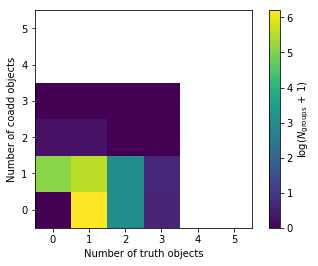

In [22]:
# now we want to count the number of truth and coadd objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the coadd
truth_mask = results['catalog_key'] == 'truth'
coadd_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_coadd = np.bincount(results['group_id'][coadd_mask], minlength=n_groups)

# now n_truth and n_coadd are the number of truth/coadd objects in each group
# we want to make a 2d histrogram of (n_truth, n_coadd). 
n_max = max(n_truth.max(), n_coadd.max()) + 1
hist_2d = np.bincount(n_coadd * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of coadd objects');
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [23]:
# Let's further inspect the objects in the groups that have 1-to-1 truth/coadd match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/coadd match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_coadd == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
coadd_idx = results['row_index'][one_to_one_group_mask & coadd_mask]

In [24]:
# Let's further inspect the objects in the groups that have 2-to-2 truth/coadd match.
# This group will contain mis-detected objects.
# first, let's find our the IDs of the groups that have 2-to-2 truth/coadd match:
two_to_two_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 2) & (n_coadd == 2)))
# and then we can find the row indices in the *original* truth/coadd catalogs for those 2-to-2 groups
truth_idx22 = results['row_index'][two_to_two_group_mask & truth_mask]
coadd_idx22 = results['row_index'][two_to_two_group_mask & coadd_mask]

In [25]:
# Check number of objects in each group.
print (len(truth_idx))
print (len(coadd_idx))
print (len(truth_idx22))
print (len(coadd_idx22))

364837
364837
0
0


In [26]:
## Now generate a numpy array 
cafields=['mag_u_cModel','mag_g_cModel','mag_r_cModel','mag_i_cModel','mag_z_cModel','mag_y_cModel',
        'magerr_u','magerr_g','magerr_r','magerr_i','magerr_z', 'magerr_y']
capzfields=['photoz_mode'] ##photozpdf is a special case
tfields=['redshift']
otype=[]
for f in cafields:
    otype.append((f,coadd_data[f].dtype))
for f in capzfields:
    otype.append((f,coadd_data_pz[f].dtype))
for f in tfields:
    otype.append((f,truth_data[f].dtype))
otype.append(('photoz_pdf','101f8'))
out=np.empty(len(coadd_idx),dtype=otype)
for f in cafields:
    out[f]=coadd_data[f][coadd_idx]
for f in capzfields:
    out[f]=coadd_data_pz[f][coadd_idx]
for f in tfields:
    out[f]=truth_data[f][truth_idx]
out['photoz_pdf']=coadd_data_pz['photoz_pdf'][coadd_idx,:]

In [27]:
np.savez('sampledeftoy',out)